# Pedestrian_Tracking Main

created by wendycao 01/2025

#### When running in google colab:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/
!git clone  "https://github.com/wendycao411/Pedestrian_Tracking.git"

/content
Cloning into 'Pedestrian_Tracking'...
remote: Enumerating objects: 374, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 374 (delta 2), reused 2 (delta 2), pack-reused 371 (from 2)
Receiving objects: 100% (374/374), 138.33 MiB | 4.23 MiB/s, done.
Resolving deltas: 100% (144/144), done.


#### Install all dependencies

In [3]:
%cd /content/Pedestrian_Tracking

/content/Pedestrian_Tracking


In [4]:
%pip install -e ".[dev]"

Obtaining file:///content/Pedestrian_Tracking
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.8/239.8 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.3/264.3 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:0

Ensure that numpy is the correct version (float is deprecated or smth so we need to use a less recent version)

In [1]:
%pip show numpy
%pip uninstall numpy -y
%pip install "numpy<1.24"

Name: numpy
Version: 1.26.4
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2023, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:

    * Redistributions of source code must retain the above copyright
       notice, this list of conditions and the following disclaimer.

    * Redistributions in binary form must reproduce the above
       copyright notice, this list of conditions and the following
       disclaimer in the documentation and/or other materials provided
       with the distribution.

    * Neither the name of the NumPy Developers nor the names of any
       contributors may be used to endorse or promote products derived
       from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYR

In [1]:
%pip install os-sys
%pip install roboflow
%pip install inference_sdk
%pip install easydict

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of os-sys to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of os-sys to determine which version is compatible with other requirements. This could take a while.
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

#### Download videos from Google Drive (requires the download link)

*How to generate the download link:*


1.   Get the "Share Link" for the video (make sure anyone can view the video!) - e.g. https://drive.google.com/file/d/1CNjE7CWTuyqgm-zTRGk5qIxSDG8A7P7q/view?usp=drive_link
2.   Get the ID for the video, which is in between the /d/ and /view - e.g. 1CNjE7CWTuyqgm-zTRGk5qIxSDG8A7P7q
3.   Paste the ID in this link: https://drive.google.com/uc?id=(ID HERE)&export=download -- e.g. https://drive.google.com/uc?id=1CNjE7CWTuyqgm-zTRGk5qIxSDG8A7P7q&export=download
4.   Done!



In [1]:
%cd /content/Pedestrian_Tracking/raw_data

/content/Pedestrian_Tracking/raw_data


In [2]:
!gdown https://drive.google.com/uc?id=1CNjE7CWTuyqgm-zTRGk5qIxSDG8A7P7q&export=download

Downloading...
From (original): https://drive.google.com/uc?id=1CNjE7CWTuyqgm-zTRGk5qIxSDG8A7P7q
From (redirected): https://drive.google.com/uc?id=1CNjE7CWTuyqgm-zTRGk5qIxSDG8A7P7q&confirm=t&uuid=65699ed2-8138-45a6-a55e-8b27bc98d368
To: /content/Pedestrian_Tracking/raw_data/2023-06-26 truncated 5fps.mp4
100% 330M/330M [00:06<00:00, 54.7MB/s]


#### Preprocessing (make time lapse, skip frames, etc.)

In [3]:
import os
import cv2

video_path = "/content/Pedestrian_Tracking/ultralytics/yolo/data/Kabukicho_240825.mov"
file_name = os.path.splitext(os.path.basename(video_path))[0]

print(file_name)

Kabukicho_240825


In [ ]:
# video preprocessing

# option 1 Adjust the frame rate to 5 FPS, and the total duration remains unchanged
!ffmpeg -i "/content/Pedestrian_Tracking/ultralytics/yolo/data/Kabukicho_240825.mov" -r 5 "/content/Pedestrian_Tracking/5fps/Kabukicho_240825_5fps.mp4"


# NOT WORKING YET!!
# # option 2 function: subsample/time lapse video
# def subsample_video(input_path, output_path, time_lapse_interval):
#     cap = cv2.VideoCapture(input_path)
#     if not cap.isOpened():
#         print("Error: Couldn't open video file.")
#         return

#     frame_count = 0
#     fps = cap.get(cv2.CAP_PROP_FPS)
#     width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#     height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#     codec = cv2.VideoWriter_fourcc(*'XVID')
#     out = cv2.VideoWriter(output_path, codec, fps, (width, height))

#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             break

#         # Collect one frame out of every xx frames
#         if frame_count % time_lapse_interval == 0:
#             out.write(frame)

#         frame_count += 1

#     cap.release()
#     out.release()
#     #cv2.destroyAllWindows()

# if __name__ == "__main__":
#     time_lapse_interval = 5 # change here
#     input_file = video_path
#     output_file = f"/content/Pedestrian_Tracking/timelapsed/{file_name}_timelapsed{time_lapse_interval}.mp4"  # Replace with desired output video file path
#     subsample_video(input_file, output_file, time_lapse_interval)
#     print(f"saved to {output_file}")

saved to /content/Pedestrian_Tracking/timelapsed/Kabukicho_240825_timelapsed5.mp4


In [5]:
video_path = "/content/Pedestrian_Tracking/raw_data/2023-06-26_truncated_5fps.mp4"
file_name = os.path.splitext(os.path.basename(video_path))[0]

print(video_path)
print(file_name)

/content/Pedestrian_Tracking/raw_data/2023-06-26_truncated_5fps.mp4
2023-06-26_truncated_5fps


In [6]:
# number of frames in the video
cap = cv2.VideoCapture(video_path)

# Get the file name
file_name = os.path.splitext(os.path.basename(video_path))[0]

# Get the total number of frames of the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
original_fps = cap.get(cv2.CAP_PROP_FPS)

print(f"The total number of frames in the video：{total_frames}\nVideo frame rate：{original_fps}")
cap.release()

The total number of frames in the video：9017
Video frame rate：30.0


#### Moving to the Required Directory

In [7]:
%cd /content/Pedestrian_Tracking/ultralytics/yolo/v8/segment

/content/Pedestrian_Tracking/ultralytics/yolo/v8/segment


#### To implement the DeepSORT tracking, downloading the required files (only needs to be done once at the beginnning of running the code)

In [8]:
!gdown "https://drive.google.com/uc?id=11ZSZcG-bcbueXZC3rN08CM0qqX3eiHxf&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=11ZSZcG-bcbueXZC3rN08CM0qqX3eiHxf&confirm=t
To: /content/Pedestrian_Tracking/ultralytics/yolo/v8/segment/deep_sort_pytorch.zip
100% 43.1M/43.1M [00:00<00:00, 68.7MB/s]


In [9]:
!unzip 'deep_sort_pytorch.zip'

Archive:  deep_sort_pytorch.zip
  inflating: deep_sort_pytorch/.gitignore  
   creating: deep_sort_pytorch/configs/
  inflating: deep_sort_pytorch/configs/deep_sort.yaml  
  inflating: deep_sort_pytorch/deep_sort/__init__.py  
   creating: deep_sort_pytorch/deep_sort/__pycache__/
  inflating: deep_sort_pytorch/deep_sort/__pycache__/__init__.cpython-310.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/__init__.cpython-37.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/__init__.cpython-38.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/deep_sort.cpython-310.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/deep_sort.cpython-37.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/deep_sort.cpython-38.pyc  
 extracting: deep_sort_pytorch/deep_sort/deep/__init__.py  
   creating: deep_sort_pytorch/deep_sort/deep/__pycache__/
  inflating: deep_sort_pytorch/deep_sort/deep/__pycache__/__init__.cpython-310.pyc  
  inflating: deep_sort_pytorch/deep_

#### Run the Script for Segmentation with DeepSORT Tracking

In [11]:
print(video_path)

/content/Pedestrian_Tracking/raw_data/2023-06-26_truncated_5fps.mp4


In [10]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import subprocess

In [14]:
def split_video(video_path, output_base_dir, segment_duration=30):
    # Extract the video name without extension
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    # Create a folder for the video
    video_output_dir = os.path.join(output_base_dir, video_name)

    if not os.path.exists(video_output_dir):
        os.makedirs(video_output_dir)

    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = int(total_frames / fps)
    cap.release()

    for start_time in range(0, duration, segment_duration):
        end_time = min(start_time + segment_duration, duration)
        output_file = os.path.join(video_output_dir, f"segment_{start_time}_{end_time}.mp4")
        ffmpeg_extract_subclip(video_path, start_time, end_time, targetname=output_file)

In [17]:
def process_segments(video_path, output_base_dir, model):
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    video_output_dir = os.path.join(output_base_dir, video_name)

    segment_files = [os.path.join(video_output_dir, f) for f in os.listdir(video_output_dir) if f.endswith('.mp4')]
    for segment in segment_files:
        print(f"Processing {segment}")
        # Run the predict.py script on each segment
        subprocess.run(["python", "predict.py", f"model={model}", f"source={segment}"])

# Define your video path and model
video_path = "/content/Pedestrian_Tracking/raw_data/2023-06-26_truncated_5fps.mp4"
output_base_dir = "/content/Pedestrian_Tracking/segments"
model = "yolov8x-seg.pt"

# Split the video into segments
split_video(video_path, output_base_dir)

# Process each segment
process_segments(video_path, output_base_dir, model)

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Processing /content/Pedestrian_Tracking/segments/2023-06-26_truncated_5fps/segment_120_150.mp4
Processing /content/Pedestrian_Tracking/segments/2023-06-26_truncated_5fps/segment_90_120.mp4
Processing /content/Pedestrian_Tracking/segments/2023-06-26_truncated_5fps/segment_240_270.mp4
Processing /content/Pedest

In [ ]:
#to run full video

!python predict.py model=yolov8x-seg.pt source="/content/Pedestrian_Tracking/raw_data/2023-06-26_truncated_5fps.mp4"

[2025-01-24 21:10:48,313][root.tracker][INFO] - Loading weights from deep_sort_pytorch/deep_sort/deep/checkpoint/ckpt.t7... Done!
2025-01-24 21:10:48.762008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-24 21:10:48.782062: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-24 21:10:48.789586: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 21:10:48.806667: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX51

#### Display the Demo Video (or you can simply download it)

In [ ]:
%pwd

'/content/Pedestrian_Tracking/ultralytics/yolo/v8/segment'

In [ ]:
!rm "result_compressed.mp4"

rm: cannot remove 'result_compressed.mp4': No such file or directory


In [ ]:
# from IPython.display import HTML
# from base64 import b64encode
# import os

# # Input video path
# save_path = r"C:\Users\jgcao\Desktop\Wendy's Stuff\VS Code\YOLOv8_Segmentation_DeepSORT_Object_Tracking\runs\detect\train6\2024-07-26 truncated timelapse.mp4"

# # Compressed video path
# compressed_path = "result_compressed.mp4"

# os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# # Show video
# mp4 = open(compressed_path,'rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# HTML("""
# <video width=400 controls>
#       <source src="%s" type="video/mp4">
# </video>
# """ % data_url)

## (wip) Data Analysis

In [ ]:
%pip install pandas
%pip install matplotlib

In [ ]:
#data visualization
import pandas as pd
import matplotlib.pyplot as plt

#### Simple Analysis on Number of People in Shadow

the csv file will save in the raw-data folder (or wherever the video to be processed is found) instead of the train folder, I'll probably fix it later since it's not that high priority

      Frame  in_shadow  out_shadow
0         0          0           0
1         1          0           0
2         2          0           0
3         3          2           4
4         4          2           4
...     ...        ...         ...
2731   2731          5           2
2732   2732          5           2
2733   2733          3           5
2734   2734          3           5
2735   2735          3           5

[2736 rows x 3 columns]


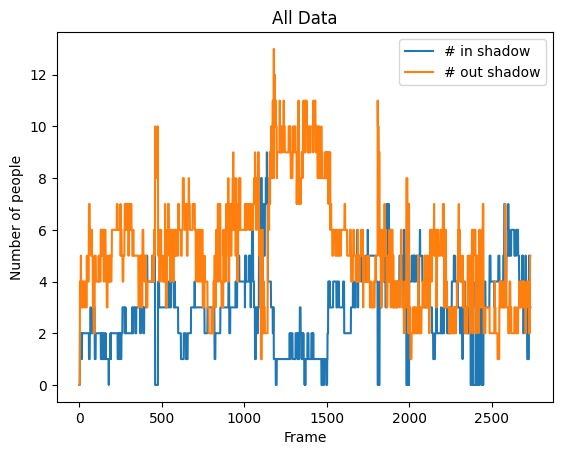

In [ ]:
csv_file = "/content/Pedestrian_Tracking/raw-data/2023-06-26_truncated_5fps_output_tracking_data.csv"
data = pd.read_csv(csv_file)
num_in_shadow = {}
num_out_shadow = {}

for i in range(data['frame'].nunique()):
  count = len(data[(data['in_shadow'] == True) & (data['frame'] == i)])
  num_in_shadow[i] = count
  count = len(data[(data['in_shadow'] == False) & (data['frame'] == i)])
  num_out_shadow[i] = count

df = pd.DataFrame([num_in_shadow, num_out_shadow]).T
df.columns = ['in_shadow', 'out_shadow']
df.reset_index(inplace=True)

# Optional: Rename the index column
df.rename(columns={'index': 'Frame'}, inplace=True)

print(df)

fig, ax = plt.subplots()
ax.plot(df['Frame'], df['in_shadow'], label='# in shadow')
ax.plot(df['Frame'], df['out_shadow'], label='# out shadow')
ax.legend()

ax.set_xlabel('Frame')
ax.set_ylabel('Number of people')
plt.title("All Data")

plt.show()

#### Moving Average

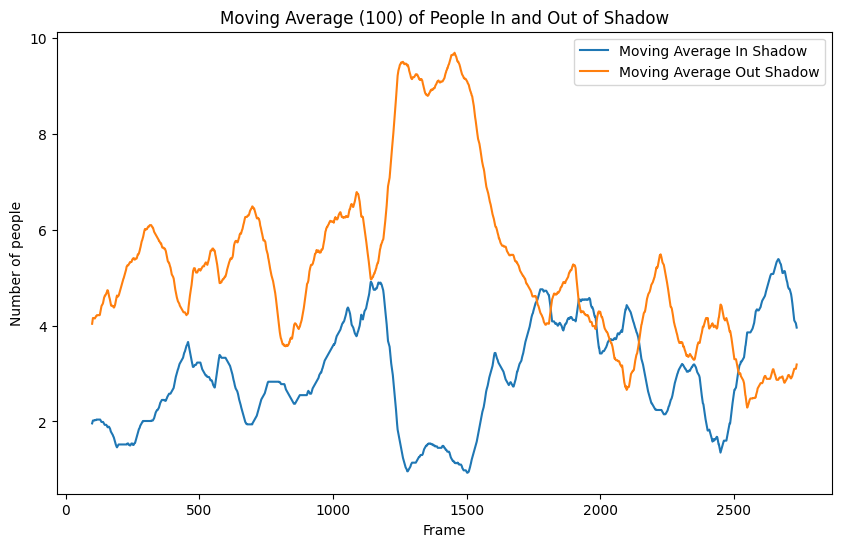

In [ ]:
# Calculate the moving average for 'out_shadow'
#edit window
df['ma_out_shadow'] = df['out_shadow'].rolling(window=100).mean()

df['ma_in_shadow'] = df['in_shadow'].rolling(window=100).mean()

# Plot the moving averages
plt.figure(figsize=(10, 6))
plt.plot(df['Frame'], df['ma_in_shadow'], label='Moving Average In Shadow')
plt.plot(df['Frame'], df['ma_out_shadow'], label='Moving Average Out Shadow')
plt.legend()
plt.xlabel('Frame')
plt.ylabel('Number of people')
plt.title('Moving Average (100) of People In and Out of Shadow')
plt.show()

#### Group coordinates for each ID

In [ ]:
# Load the CSV data
data = pd.read_csv('tracking_data.csv')

# Group data by person_id and aggregate coordinates and in_shadow status into a list of tuples
grouped_data = data.groupby('person_id').apply(lambda x: list(zip(x['bottom_mid_x'], x['bottom_mid_y'], x['in_shadow']))).reset_index()
grouped_data.columns = ['person_id', 'coordinates_and_shadow']

# Display the grouped data
print(grouped_data)

#### Scatter Plot

In [ ]:
% pip install seaborn

In [ ]:
import seaborn as sns

# Load the CSV data into a DataFrame
data = pd.read_csv('csv_file.csv')  # Ensure your file name is correct

# Create a scatter plot of object positions
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='bottom_mid_x',
    y='bottom_mid_y',
    data=data,
    s=50,  # Adjust the size of the dots
    alpha=0.6,  # Adjust the transparency of the dots
    color='blue'
)
plt.gca().invert_yaxis()
plt.title('Object Positions Scatter Plot')
plt.xlabel('Centroid X')
plt.ylabel('Centroid Y')
plt.show()


#### Paths Plot

In [ ]:
# Group data by object ID
grouped_data = data.groupby('id')

plt.figure(figsize=(12, 8))
for object_id, group in grouped_data:
    plt.plot(group['centroid_x'], group['centroid_y'], label=f'Object {object_id}')
plt.gca().invert_yaxis()
plt.xlabel('Centroid X')
plt.ylabel('Centroid Y')
plt.title('Object Paths')
plt.legend()
plt.show()

#### Object Density

In [ ]:
# Load the CSV data into a DataFrame
data = pd.read_csv('csv_file.csv')  # Ensure your file name is correct

# Create a heatmap of object densities
heatmap_data = data.pivot_table(index='bottom_mid_y', columns='bottom_mid_x', aggfunc='size', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis')
plt.gca().invert_yaxis()  # Correct the flipped y-axis
plt.title('Object Density Heatmap')
plt.xlabel('Centroid X')
plt.ylabel('Centroid Y')
plt.show()